### Top

1. Analysis and preparation of data
2. Basic models
3. Hyperparam optimization

In [1]:
# Importy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold 
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
import catboost as cat
import shap
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

from sklearn.model_selection import cross_val_score



c:\Users\trswc\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("../data/raw/cars.csv")

### 1. Analysis and preparation of data

In [3]:
# Limitting price to below 250k to exclude extreme values

df = df[df['cena'] < 250_000]

In [4]:
df.head(3)

,Id,Tytuł,lokalizacja,tekst,Wystawiający,Marka,Model,Rok_produkcji,Pojemnosc_silnika,Paliwo,KM,Przebieg,Typ_nadwozia,Kolor,Stan,Skrzynia_biegow,Kraj_pochodzenia,Kierownica,cena
0,9993,"Kia Cee'd 1,6 kombi, 115 km, niski przebieg, z...",Giżycko,Witam sprzedaję niezawodne dynamiczne 115km i...,Osoby prywatnej,Kia,Cee'd,2008,1 600 cm³,Benzyna,115 KM,149 000 km,Kombi,Srebrny,Nieuszkodzony,Manualna,Polska,po lewej,15500
1,406,Volkswagen Golf VII 7 DSG salon Polska vw serw...,Zawiercie,Sprzedam pięknego VW Golf 7 z najlepszym ekon...,Osoby prywatnej,Volkswagen,Golf,2015,1 600 cm³,Diesel,115 KM,91 500 km,Kombi,Czarny,Nieuszkodzony,Automatyczna,Polska,po lewej,46900
2,28999,Titanium Convers+ 2.2tdci 175koni Super Stan P...,Lgota,Sprzedam przepieknego Forda Mondeo mk4 z 2009...,Firmy,Ford,Mondeo,2009,2 200 cm³,Diesel,175 KM,179 000 km,Kombi,Czarny,Nieuszkodzony,Manualna,Niemcy,po lewej,22900


In [5]:
df.isnull().sum()

Id                      0
Tytuł                   0
lokalizacja             0
tekst                   0
Wystawiający            0
Marka                   0
Model                   0
Rok_produkcji           0
Pojemnosc_silnika     596
Paliwo                  0
KM                   3138
Przebieg                0
Typ_nadwozia            0
Kolor                   0
Stan                    0
Skrzynia_biegow         0
Kraj_pochodzenia     6503
Kierownica           6375
cena                    0
dtype: int64

In [6]:
df.describe()

,Id,Rok_produkcji,cena
count,26614.000000,26614.000000,26614.000000
mean,18980.209439,2005.526452,16588.330841
std,10978.722121,6.067714,19755.630492
min,0.000000,1900.000000,300.000000
25%,9455.250000,2002.000000,5200.000000
50%,18911.500000,2006.000000,10700.000000
75%,28494.750000,2009.000000,19900.000000
max,38057.000000,2022.000000,249900.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26614 entries, 0 to 26639
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Id                 26614 non-null  int64 
 1   Tytuł              26614 non-null  object
 2   lokalizacja        26614 non-null  object
 3   tekst              26614 non-null  object
 4   Wystawiający       26614 non-null  object
 5   Marka              26614 non-null  object
 6   Model              26614 non-null  object
 7   Rok_produkcji      26614 non-null  int64 
 8   Pojemnosc_silnika  26018 non-null  object
 9   Paliwo             26614 non-null  object
 10  KM                 23476 non-null  object
 11  Przebieg           26614 non-null  object
 12  Typ_nadwozia       26614 non-null  object
 13  Kolor              26614 non-null  object
 14  Stan               26614 non-null  object
 15  Skrzynia_biegow    26614 non-null  object
 16  Kraj_pochodzenia   20111 non-null  object
 17

In [8]:
df['Wystawiający'].value_counts()

Wystawiający
Osoby prywatnej    19504
Firmy               7110
Name: count, dtype: int64

In [9]:
# Cleaning data per column

df['KM'] = df['KM'].str.replace(" KM","").str.replace(" ","").astype(float)
df['Pojemnosc_silnika'] = df['Pojemnosc_silnika'].str.replace(" cm³","").str.replace(" ","").astype(float)
df['Przebieg'] = df['Przebieg'].str.replace(" km","").str.replace(" ","").astype(float)

df['KM'] = df['KM'].fillna(df['KM'].mean()).astype(float)


df['Pojemnosc_silnika'] = df['Pojemnosc_silnika'].fillna(df['Pojemnosc_silnika'].mean())      
df['Kierownica'] = df['Kierownica'].fillna('other')
df['Kraj_pochodzenia'] = df['Kraj_pochodzenia'].fillna('other')

df['Pojemnosc_silnika'] = df['Pojemnosc_silnika'].astype(int)
df['Przebieg'] = df['Przebieg'].astype(int)
df['KM'] = df['KM'].astype(int)

df = df[df['KM']>20]
df = df[df['Pojemnosc_silnika']>800]
df = df[df['Rok_produkcji']>1980]

df['KM'] = df['KM'].fillna(df['KM'].mean())
df['Pojemnosc_silnika'] = df['Pojemnosc_silnika'].fillna(df['Pojemnosc_silnika'].mean())

In [10]:
df.head(3)

,Id,Tytuł,lokalizacja,tekst,Wystawiający,Marka,Model,Rok_produkcji,Pojemnosc_silnika,Paliwo,KM,Przebieg,Typ_nadwozia,Kolor,Stan,Skrzynia_biegow,Kraj_pochodzenia,Kierownica,cena
0,9993,"Kia Cee'd 1,6 kombi, 115 km, niski przebieg, z...",Giżycko,Witam sprzedaję niezawodne dynamiczne 115km i...,Osoby prywatnej,Kia,Cee'd,2008,1600,Benzyna,115,149000,Kombi,Srebrny,Nieuszkodzony,Manualna,Polska,po lewej,15500
1,406,Volkswagen Golf VII 7 DSG salon Polska vw serw...,Zawiercie,Sprzedam pięknego VW Golf 7 z najlepszym ekon...,Osoby prywatnej,Volkswagen,Golf,2015,1600,Diesel,115,91500,Kombi,Czarny,Nieuszkodzony,Automatyczna,Polska,po lewej,46900
2,28999,Titanium Convers+ 2.2tdci 175koni Super Stan P...,Lgota,Sprzedam przepieknego Forda Mondeo mk4 z 2009...,Firmy,Ford,Mondeo,2009,2200,Diesel,175,179000,Kombi,Czarny,Nieuszkodzony,Manualna,Niemcy,po lewej,22900


In [11]:
df['Wystawiający'].unique()
df['Skrzynia_biegow'].unique()
df['Stan'].unique()

df = pd.concat([df, pd.get_dummies(df['Wystawiający']).astype(int)], axis = 1)
df = pd.concat([df, pd.get_dummies(df['Skrzynia_biegow']).astype(int)], axis = 1)
df = pd.concat([df, pd.get_dummies(df['Stan']).astype(int)], axis = 1)


df = df.drop(columns = ['Tytuł', 
                        'tekst',
                        'Wystawiający', 
                        'Firmy',
                        'Stan', 
                        'Nieuszkodzony',
                        'Id',
                        'lokalizacja',
                        'Skrzynia_biegow'
                        ])

In [12]:
def agg_data_simple(data, agg_feat, feat):
        tmp = data.groupby(agg_feat).agg(
            min_=(feat, min),
            perc_5=(feat, lambda x: np.percentile(x, 5)),
            perc_25=(feat, lambda x: np.percentile(x, 25)),
            perc_50=(feat, lambda x: np.percentile(x, 50)),
            mean=(feat, "mean"),
            perc_75=(feat, lambda x: np.percentile(x, 75)),
            perc_95=(feat, lambda x: np.percentile(x, 95)),
            max_=(feat, max),
            _n_=(feat, "count"),
        ).round(2)
        return tmp

In [13]:
def funkcja(col):

    dfTemp = df
    dfTemp['cena log'] = np.log(dfTemp.cena)

    print(col)

    print('-------------------unique------------------------')
    print(df[col].unique())
    print()
    print('-------------------describe------------------------')
    display(df[col].describe())
    df[col].hist()
    plt.show()
    plt.figure()

    print()
    print('-------------------scatterplot------------------------')

    sns.scatterplot(x = col, y = 'cena', data = df).set_title(f'{col} - cena')
    plt.show()
    sns.scatterplot(x = col, y = 'cena log', data = df).set_title(f'{col} - cena log')
    plt.show()
    print()
    print('-------------------boxplot------------------------')

    sns.boxplot(x = col, y = 'cena', data = df).set_title(f'{col} - cena')
    plt.show()
    sns.boxplot(x = col, y = 'cena log', data = dfTemp).set_title(f'{col} - cena log')
    plt.show()
    print()
    print('-------------------agg_data_simple------------------------')
    print(agg_data_simple(df, col, 'cena'))

In [14]:
df.columns

Index(['Marka', 'Model', 'Rok_produkcji', 'Pojemnosc_silnika', 'Paliwo', 'KM',
       'Przebieg', 'Typ_nadwozia', 'Kolor', 'Kraj_pochodzenia', 'Kierownica',
       'cena', 'Osoby prywatnej', 'Automatyczna', 'Manualna', 'Uszkodzony'],
      dtype='object')

Paliwo
-------------------unique------------------------
['Benzyna' 'Diesel' 'LPG' 'CNG i Hybryda' 'Elektryczny']

-------------------describe------------------------


count      25530
unique         5
top       Diesel
freq       11566
Name: Paliwo, dtype: object

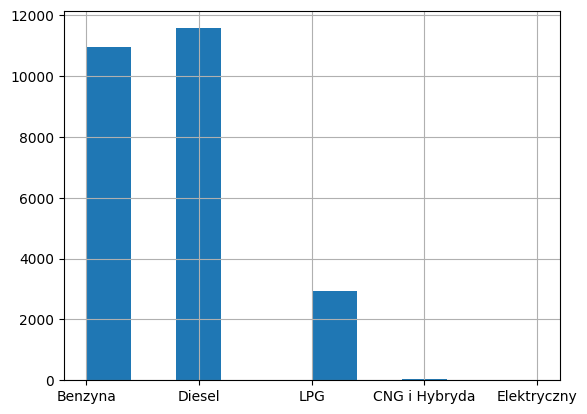


-------------------scatterplot------------------------


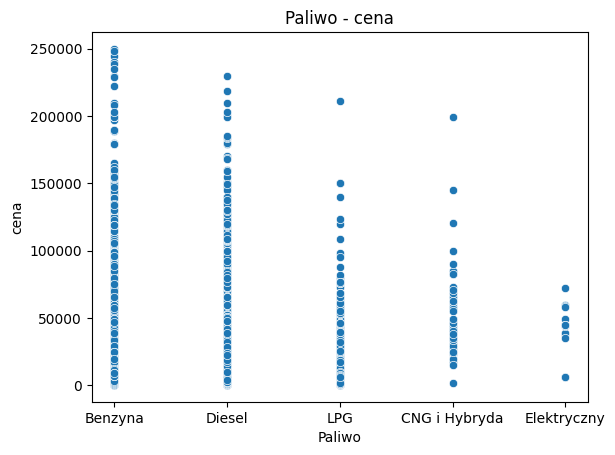

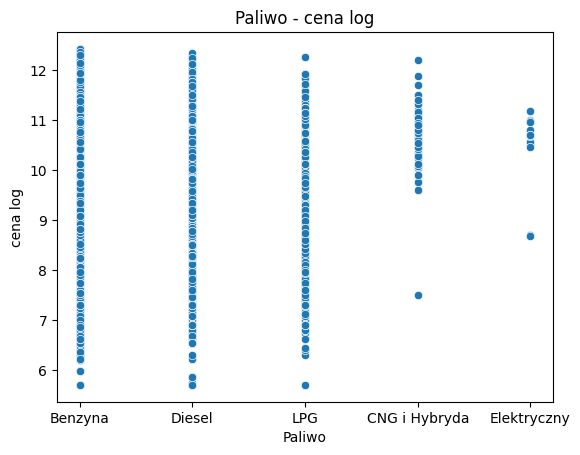


-------------------boxplot------------------------


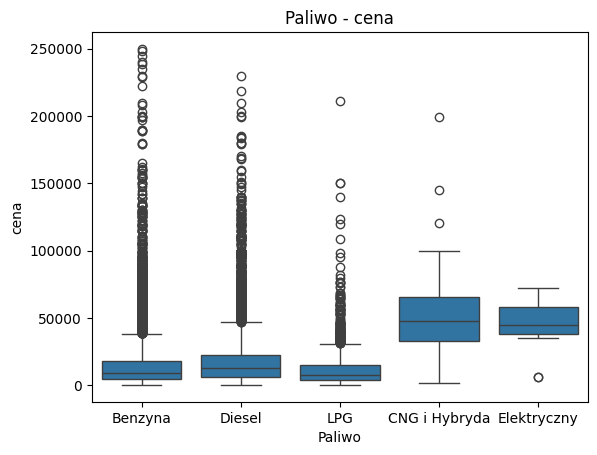

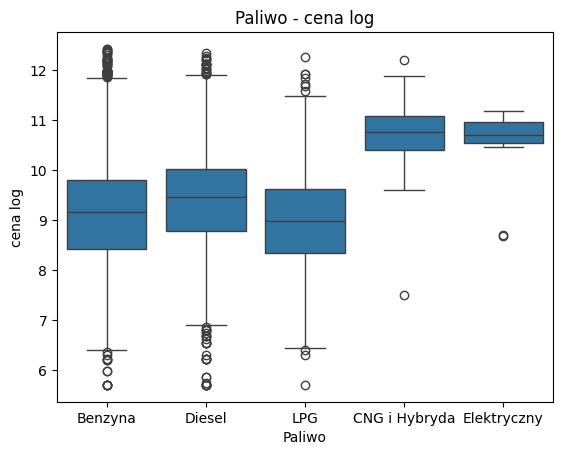


-------------------agg_data_simple------------------------
               min_   perc_5  perc_25  perc_50      mean  perc_75   perc_95  \
Paliwo                                                                        
Benzyna         300   1899.0   4600.0   9500.0  15798.53  17999.0   53000.0   
CNG i Hybryda  1800  18600.0  33250.0  47500.0  53995.25  65900.0  109315.0   
Diesel          300   2600.0   6500.0  12990.0  18372.28  22800.0   53900.0   
Elektryczny    5950   5979.4  37900.0  44900.0  42765.31  58000.0   64740.0   
LPG             300   1950.0   4175.0   7999.0  11785.45  15000.0   32000.0   

                 max_    _n_  
Paliwo                        
Benzyna        249900  10959  
CNG i Hybryda  199000     52  
Diesel         230000  11566  
Elektryczny     72000     13  
LPG            210900   2940  


C:\Users\trswc\AppData\Local\Temp\ipykernel_25236\4247767051.py:2: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  tmp = data.groupby(agg_feat).agg(
C:\Users\trswc\AppData\Local\Temp\ipykernel_25236\4247767051.py:2: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  tmp = data.groupby(agg_feat).agg(


In [15]:
funkcja('Paliwo')

In [16]:
df.head(2)

,Marka,Model,Rok_produkcji,Pojemnosc_silnika,Paliwo,KM,Przebieg,Typ_nadwozia,Kolor,Kraj_pochodzenia,Kierownica,cena,Osoby prywatnej,Automatyczna,Manualna,Uszkodzony,cena log
0,Kia,Cee'd,2008,1600,Benzyna,115,149000,Kombi,Srebrny,Polska,po lewej,15500,1,0,1,0,9.648595
1,Volkswagen,Golf,2015,1600,Diesel,115,91500,Kombi,Czarny,Polska,po lewej,46900,1,1,0,0,10.755773


In [17]:
y = df['cena'] 
X = df.drop(columns=['cena', 'Marka', 'Model', 'Paliwo', 'Typ_nadwozia', 'Kolor', 'Kraj_pochodzenia', 'Kierownica']).copy() 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=200)
X_train.shape,y_train.shape, X_test.shape, y_test.shape

((17871, 9), (17871,), (7659, 9), (7659,))

In [18]:
features = [
            'Rok_produkcji',
            'Pojemnosc_silnika',
            'Przebieg',
            'KM',
            'Osoby prywatnej',
            'Uszkodzony',
            'Manualna'
                ]

### 2. Basic models

In [19]:
model = DecisionTreeRegressor(max_depth=5)
model.fit(X_train[features], y_train)

y_pred_train = model.predict(X_train[features])
y_pred_test = model.predict(X_test[features])

mae_train = mae(y_train, y_pred_train).round(2)
mae_test = mae(y_test, y_pred_test).round(2)

print("MAE Train: ", mae_train)
print("MAE Test: ", mae_test)
print("Różnica MAE: ", round(mae_train - mae_test,2) )

MAE Train:  5932.65
MAE Test:  6263.29
Różnica MAE:  -330.64


In [20]:
model = RandomForestRegressor(max_depth=6, n_estimators = 100)
model.fit(X_train[features], y_train)

y_pred_train = model.predict(X_train[features])
y_pred_test = model.predict(X_test[features])

mae_train = mae(y_train, y_pred_train).round(2)
mae_test = mae(y_test, y_pred_test).round(2)

print("MAE Train: ", mae_train)
print("MAE Test: ", mae_test)
print("Różnica MAE: ", round(mae_train - mae_test,2) )

MAE Train:  5252.54
MAE Test:  5607.66
Różnica MAE:  -355.12


In [21]:
model = xgb.XGBRegressor(max_depth=2, n_estimators = 100)
model.fit(X_train[features], y_train)

y_pred_train = model.predict(X_train[features])
y_pred_test = model.predict(X_test[features])

mae_train = mae(y_train, y_pred_train).round(2)
mae_test = mae(y_test, y_pred_test).round(2)

print("MAE Train: ", mae_train)
print("MAE Test: ", mae_test)
print("Różnica MAE: ", round(mae_train - mae_test,2) )

MAE Train:  5057.66
MAE Test:  5359.37
Różnica MAE:  -301.71


In [22]:
df.head(2)

,Marka,Model,Rok_produkcji,Pojemnosc_silnika,Paliwo,KM,Przebieg,Typ_nadwozia,Kolor,Kraj_pochodzenia,Kierownica,cena,Osoby prywatnej,Automatyczna,Manualna,Uszkodzony,cena log
0,Kia,Cee'd,2008,1600,Benzyna,115,149000,Kombi,Srebrny,Polska,po lewej,15500,1,0,1,0,9.648595
1,Volkswagen,Golf,2015,1600,Diesel,115,91500,Kombi,Czarny,Polska,po lewej,46900,1,1,0,0,10.755773


### 3. Hyperparam optimization

In [23]:
# Defining hyperparam grid
param_grid = {
    'criterion': ['poisson', 'absolute_error','squared_error'],
    'max_depth': [None] + list(range(1, 30)),
    'min_samples_split': list(range(2, 20)),
    'min_samples_leaf': list(range(1, 20))
}

# Inicjalizacja Grid Search
model = DecisionTreeRegressor(random_state = 42)
grid_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter = 100, cv=2, scoring='neg_mean_absolute_error', n_jobs=-1)

# Uruchomienie procesu wyszukiwania
grid_search.fit(X_train, y_train)

# Wyświetlenie najlepszych parametrów
print("Najlepsze parametry:", grid_search.best_params_)

# Wyświetlenie najlepszej dokładności
print("Najlepsza dokładność:", grid_search.best_score_)

# Użycie najlepszego modelu do przewidywania na danych testowych
best_model = grid_search.best_estimator_
y_pred_test = best_model.predict(X_test)
print("MAE Test: ", mae(y_test, y_pred_test).round(2))

Najlepsze parametry: {'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 16, 'criterion': 'absolute_error'}
Najlepsza dokładność: -18.932850609870652
MAE Test:  9.71


In [24]:
model = DecisionTreeRegressor(min_samples_split= 4, min_samples_leaf= 1, max_depth= 12, criterion= 'squared_error')
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print("MAE Train: ", mae(y_train, y_pred_train).round(2))
print("MAE Test: ", mae(y_test, y_pred_test).round(2))
print("Różnica MAE: ", round(mae(y_train, y_pred_train) - mae(y_test, y_pred_test),2) )

MAE Train:  2.2
MAE Test:  8.22
Różnica MAE:  -6.03


In [25]:
space = {
    'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'max_depth': hp.choice('max_depth', [None] + list(range(1, 20))),
    'min_samples_split': hp.uniform('min_samples_split', 0.1, 1.0),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1, 0.5),
}

# Funkcja celu do minimalizacji
def objective(params):
    clf = DecisionTreeRegressor(random_state = 42)
    score = -cross_val_score(clf, X_train, y_train, scoring='neg_mean_absolute_error', cv=3).mean()
    return {'loss': score, 'status': STATUS_OK}

# Uruchomienie optymalizacji
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

print("Najlepsze znalezione hiperparametry:", best)

100%|██████████| 100/100 [00:10<00:00,  9.24trial/s, best loss: 15.352022830283701]
Najlepsze znalezione hiperparametry: {'criterion': 1, 'max_depth': 4, 'min_samples_leaf': 0.48926490836482706, 'min_samples_split': 0.8655353201388921}


In [26]:
model = DecisionTreeRegressor(criterion = 'squared_error', max_depth= 18, min_samples_leaf= 0.10933208879625633, min_samples_split= 0.7300285276455396)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print("MAE Train: ", mae(y_train, y_pred_train).round(2))
print("MAE Test: ", mae(y_test, y_pred_test).round(2))
print("Różnica MAE: ", round(mae(y_train, y_pred_train) - mae(y_test, y_pred_test),2) )

MAE Train:  5360.24
MAE Test:  5406.05
Różnica MAE:  -45.82


In [27]:
# Funkcje

def selectionVarianceThreshold(df, variance_threshold=0.0):
    sel = VarianceThreshold(threshold=variance_threshold)
    sel_var=sel.fit_transform(df)
    sel_loc_index = sel.get_support(indices=True)
 
    if len(sel_loc_index)==0:
        return None
    else: 
        return list(df.columns[sel_loc_index])


def RF_importance(data, features, YCOL, iteration = 3, sample = 0.1):
    importances_all = np.array([0.00]*len(features))
    imporances_all_plot = pd.DataFrame()

    for i in tqdm(range(iteration)):
 
        df_sample = data.sample(np.ceil(data.shape[0] * sample).astype(int))
        X_train = df_sample[df_sample['okres'] == "train"][features]
        y_train = df_sample[df_sample['okres'] == "train"][YCOL]
 
        X_test = df_sample[df_sample['okres'] != "train"][features]
        y_test = df_sample[df_sample['okres'] != "train"][YCOL]
        
        ### model change params every iteration
        RF_params = {"max_depth": 4 + i, "n_estimators": 100 + (25 * i), "random_state": i}
        model = RandomForestClassifier(**RF_params)
        if y_train.nunique() > REGRESSION_TRESH:
            model = RandomForestRegressor(**RF_params)
        model_name = model.__class__.__name__
        model.fit(X_train, y_train)
        ### importance
        importances = model.feature_importances_
        importances_all += importances
        ###importance for plot
        iteration_importance = pd.DataFrame({"Feat": X_train[features].columns,f"Importance_{model_name}": importances} )
        imporances_all_plot = pd.concat([imporances_all_plot, iteration_importance ])
 
    importance = pd.DataFrame({"Feat": X_train.columns,
                                 f"Importance_{model_name}":importances_all/iteration}).sort_values(f"Importance_{model_name}", ascending= False).reset_index(drop = True)
    importance = importance.reset_index().rename(columns = {"index":f"rank_Importance_{model_name}"})
    
    plt.figure(figsize = (10, len(features)/4))
    sns.boxplot(x = f"Importance_{model_name}", y = 'Feat', data = imporances_all_plot, order = importance['Feat'])
    plt.title(f"{model_name} importance")
    plt.show()
    
    return importance

def XGB_importance(data, features, YCOL, iteration = 3, sample = 0.1):
    importances_all = np.array([0.00]*len(features))
    imporances_all_plot = pd.DataFrame()

    for i in tqdm(range(iteration)):
 
        df_sample = data.sample(np.ceil(data.shape[0] * sample).astype(int))
        X_train = df_sample[df_sample['okres'] == "train"][features]
        y_train = df_sample[df_sample['okres'] == "train"][YCOL]
 
        X_test = df_sample[df_sample['okres'] != "train"][features]
        y_test = df_sample[df_sample['okres'] != "train"][YCOL]
        
        ### model change params every iteration
        RF_params = {"max_depth": 4 + i, "n_estimators": 100 + (25 * i), "random_state": i}
        model = xgb.XGBClassifier(**RF_params)

        if y_train.nunique() > REGRESSION_TRESH:
            model = xgb.XGBRegressor(**RF_params)
            
        model_name = model.__class__.__name__
        model.fit(X_train, y_train)
        ### importance
        importances = model.feature_importances_
        importances_all += importances
        ###importance for plot
        iteration_importance = pd.DataFrame({"Feat": X_train[features].columns,f"Importance_{model_name}": importances} )
        imporances_all_plot = pd.concat([imporances_all_plot, iteration_importance ])
 
    importance = pd.DataFrame({"Feat": X_train.columns,
                                 f"Importance_{model_name}":importances_all/iteration}).sort_values(f"Importance_{model_name}", ascending= False).reset_index(drop = True)
    importance = importance.reset_index().rename(columns = {"index":f"rank_Importance_{model_name}"})
    
    plt.figure(figsize = (10, len(features)/4))
    sns.boxplot(x = f"Importance_{model_name}", y = 'Feat', data = imporances_all_plot, order = importance['Feat'])
    plt.title(f"{model_name} importance")
    plt.show()
    
    return importance

def RFE_importance(data, features, YCOL, iteration = 3, sample = 0.1):
    
    importances_all = np.array([0.00]*len(features))
    
    for i in tqdm(range(iteration)):
    
        df_sample = data.sample(np.ceil(data.shape[0] * sample).astype(int))
        X_train = df_sample[df_sample['okres'] == "train"][features]
        y_train = df_sample[df_sample['okres'] == "train"][YCOL]
 
        ### model change params every iteration
        RF_params = {"max_depth": 4 + i, "n_estimators": 50 + (25 * i), "random_state": i}
        model = xgb.XGBClassifier(**RF_params)
        if y_train.nunique() > REGRESSION_TRESH:
            model = xgb.XGBRegressor(**RF_params)
            
        model.fit(X_train, y_train)
 
        selector = RFE(model, n_features_to_select= 1, step=1,  verbose=10)
        selector = selector.fit(X_train, y_train)
        importances_all += selector.ranking_
    importances_all = importances_all/iteration
    return importances_all
 
def choose_n_best(features, ranking):
    selected_features = [val[1] for val in sorted(list(zip(list(ranking),features)))]
    rank = pd.Series(selected_features).reset_index()
    rank.columns = ['rank_RFE', "Feat"]
    
    return rank

def perm_importance(data, features, YCOL, iteration = 3, sample = 0.1):
 
    df_sample = data.sample(np.ceil(data.shape[0] * sample).astype(int))
    X_train = df_sample[df_sample['okres'] == "train"][features]
    y_train = df_sample[df_sample['okres'] == "train"][YCOL]
 
    X_test = df_sample[df_sample['okres'] != "train"][features]
    y_test = df_sample[df_sample['okres'] != "train"][YCOL]
 
    RF_params = {"max_depth": 5, "n_estimators": 100, "random_state": 1, "verbose": -1}
    model = lgb.LGBMClassifier (**RF_params)
    if y_train.nunique() > REGRESSION_TRESH:
        model = lgb.LGBMRegressor(**RF_params)
        
    model.fit(X_train, y_train)
 
    result = permutation_importance(
        model, X_test, y_test, n_repeats=iteration, random_state=42, n_jobs=2, scoring = 'neg_mean_absolute_error' )
    sorted_idx = result.importances_mean.argsort()
 
    permutation_rank = pd.Series(X_test.columns[sorted_idx][::-1].to_list()).reset_index()
    permutation_rank.columns = ['rank_per', "Feat"]
 
    fig, ax = plt.subplots(figsize=(10,len(features)/4))
    ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
    ax.set_title("Permutation Importances (test set)");
    fig.tight_layout();
    plt.show();
    
    return permutation_rank

def MIC_rank(data, features, YCOL, sample = 0.1):
    
    df_sample = data.sample(np.ceil(data.shape[0] * sample).astype(int))
    X_train = df_sample[df_sample['okres'] == "train"][features]
    y_train = df_sample[df_sample['okres'] == "train"][YCOL]

    if y_train.nunique() > REGRESSION_TRESH:
        importances = mutual_info_regression(X_train[features], y_train)
    else:
        importances = mutual_info_classif(X_train[features], y_train)
 
    feature_info = pd.DataFrame({"MIC_importance" : importances,
                                 "Feat" : X_train[features].columns}).sort_values("MIC_importance",ascending=False).reset_index(drop = True).reset_index()
    
    feature_info.columns = ['rank_MIC','importance_MIC','Feat']
    return feature_info



def shap_rank(data, features, YCOL, model_params, sample = 0.1):

    df_sample = data.sample(np.ceil(data.shape[0] * sample).astype(int))
    X_train = df_sample[df_sample['okres'] == "train"][features]
    y_train = df_sample[df_sample['okres'] == "train"][YCOL]
    
    
    model = cat.CatBoostClassifier(**model_params, logging_level='Silent')
    if y_train.nunique() > REGRESSION_TRESH:
        model = cat.CatBoostRegressor(**model_params, logging_level='Silent')
    
    model.fit(X_train, y_train)
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    shap.summary_plot(shap_values, X_train)
    
    rf_resultX = pd.DataFrame(shap_values, columns = features)
    vals = np.abs(rf_resultX.values).mean(0)
    shap_importance = pd.DataFrame(list(zip(features, vals)),
                                      columns=['Feat','shap_importance']).sort_values(by=['shap_importance'], ascending=False).reset_index(drop=True).reset_index()
    shap_importance.columns = ['rank_shap', "Feat", 'shap_importance']
    

    return shap_importance

def rand_var(data = None, prefix = 'rand_'):
    data_size = data.shape[0]
    data[prefix + 'binary']  = np.random.randint(0, 2, data_size)
    data[prefix + 'cat']     = np.random.randint(0, 5, data_size)
    data[prefix + 'uniform'] = np.random.uniform(0, 1, data_size)
    data[prefix + 'normal']  = np.random.normal(0, 1, data_size)
    return(data)

In [28]:
X_train['okres'] = 'train'
X_test['okres'] = 'test'

df = pd.concat([X_train, X_test])
df['price'] = pd.concat([y_train, y_test])

df = rand_var(df)

YCOL = 'price' 

CATEGORICAL_TRESH = 10
REGRESSION_TRESH = 4

variance_threshold = 0.01
feats_to_include_VT = selectionVarianceThreshold(df[features], variance_threshold=variance_threshold)

100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


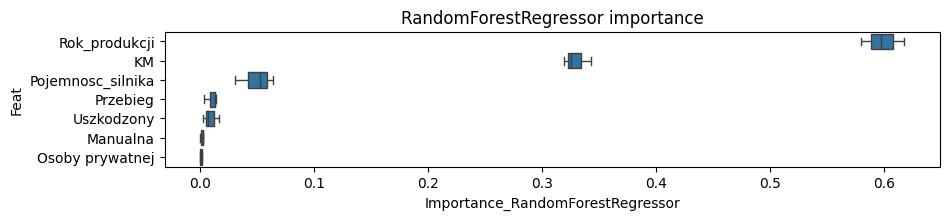

In [29]:
importance_RF = RF_importance(df, features, YCOL, sample = 0.8)

In [30]:
importance_RF

,rank_Importance_RandomForestRegressor,Feat,Importance_RandomForestRegressor
0,0,Rok_produkcji,0.598320
1,1,KM,0.329408
2,2,Pojemnosc_silnika,0.049492
3,3,Przebieg,0.010553
4,4,Uszkodzony,0.009171
5,5,Manualna,0.001836
6,6,Osoby prywatnej,0.001220


100%|██████████| 3/3 [00:00<00:00,  8.05it/s]


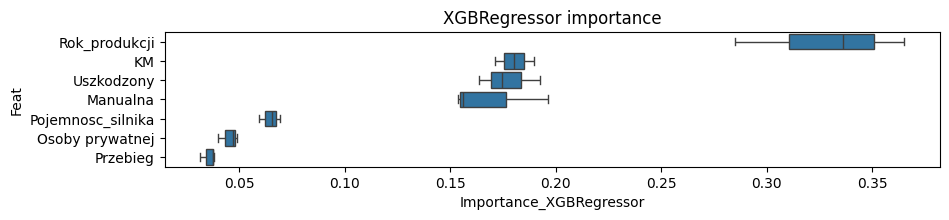

In [31]:
importance_XGB = XGB_importance(df, features, YCOL, sample = 0.8)

In [32]:
importance_XGB

,rank_Importance_XGBRegressor,Feat,Importance_XGBRegressor
0,0,Rok_produkcji,0.328940
1,1,KM,0.180324
2,2,Uszkodzony,0.176929
3,3,Manualna,0.168672
4,4,Pojemnosc_silnika,0.064581
5,5,Osoby prywatnej,0.045130
6,6,Przebieg,0.035424


c:\Users\trswc\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\trswc\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


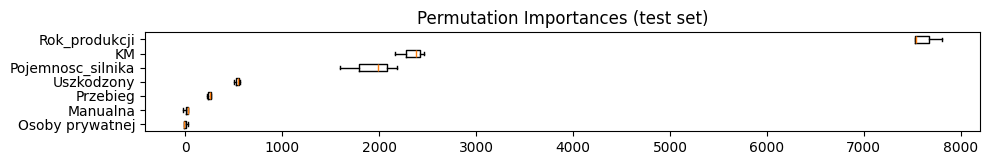

In [33]:
rank_perm = perm_importance(df, features, YCOL, iteration = 3, sample = 0.1)

In [34]:
rank_perm

,rank_per,Feat
0,0,Rok_produkcji
1,1,KM
2,2,Pojemnosc_silnika
3,3,Uszkodzony
4,4,Przebieg
5,5,Manualna
6,6,Osoby prywatnej


In [35]:
rank_MIC = MIC_rank(df, features, YCOL, sample = 1)
rank_MIC

,rank_MIC,importance_MIC,Feat
0,0,0.458197,Rok_produkcji
1,1,0.198950,KM
2,2,0.147421,Pojemnosc_silnika
3,3,0.084301,Przebieg
4,4,0.065729,Manualna
5,5,0.034348,Osoby prywatnej
6,6,0.020994,Uszkodzony


In [36]:
model_params = {"max_depth" : 7, "n_estimators" : 150, "random_state" : 1}

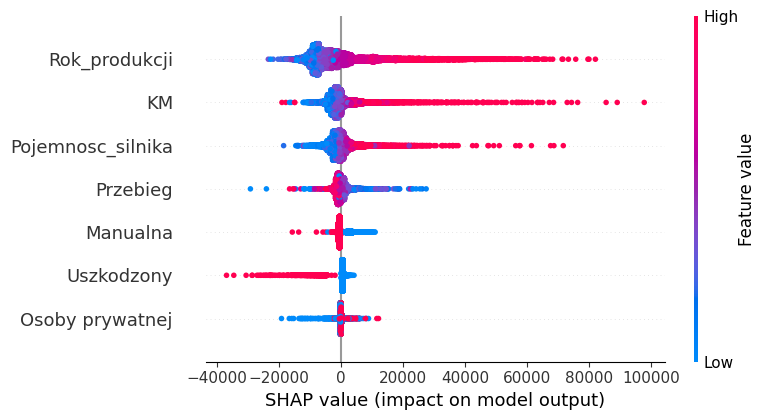

In [37]:
df_sample = df.sample(np.ceil(df.shape[0] * 1).astype(int))
X_train = df_sample[df_sample['okres'] == "train"][features]
y_train = df_sample[df_sample['okres'] == "train"][YCOL]
    
    

model = cat.CatBoostRegressor(**model_params, logging_level='Silent')
model.fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

In [38]:
shap.initjs()

In [39]:
# shap.force_plot(explainer.expected_value, shap_values, X_train) #stop po 17min

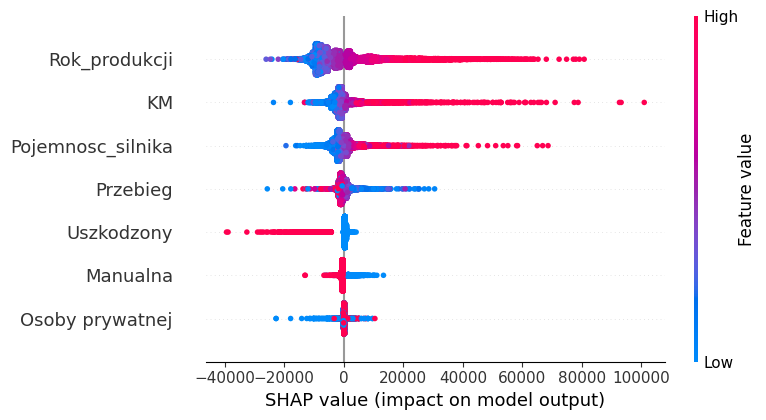

In [40]:
rank_shap =  shap_rank(df, features, YCOL, model_params, sample = 1)

In [41]:
importance_RFE = RFE_importance(df, features, YCOL, iteration = 3, sample = 1)
importance_RFE = choose_n_best(features, importance_RFE)

  0%|          | 0/3 [00:00<?, ?it/s]

Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.


 33%|███▎      | 1/3 [00:00<00:00,  3.13it/s]

Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.


 67%|██████▋   | 2/3 [00:00<00:00,  2.63it/s]

Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


In [42]:
ranks = (importance_RF.merge(importance_XGB, on = 'Feat', how = 'left')
              .merge(rank_MIC, on = 'Feat', how = 'left')
              .merge(rank_shap, on = 'Feat', how = 'left')
              .merge(importance_RFE, on = 'Feat', how = 'left')
              .merge(rank_perm, on = 'Feat', how = 'left'))
rank_feat = [col for col in ranks.columns if "rank" in col]
ranks['ranks_mean'] = ranks[rank_feat].mean(axis =1)
rank_feat = [col for col in ranks.columns if "rank" in col]

In [43]:
ranks

,rank_Importance_RandomForestRegressor,Feat,Importance_RandomForestRegressor,rank_Importance_XGBRegressor,Importance_XGBRegressor,rank_MIC,importance_MIC,rank_shap,shap_importance,rank_RFE,rank_per,ranks_mean
0,0,Rok_produkcji,0.598320,0,0.328940,0,0.458197,0,8640.470754,0,0,0.000000
1,1,KM,0.329408,1,0.180324,1,0.198950,1,3008.157238,1,1,1.000000
2,2,Pojemnosc_silnika,0.049492,4,0.064581,2,0.147421,2,2750.859063,4,2,2.666667
3,3,Przebieg,0.010553,6,0.035424,3,0.084301,3,1417.106655,6,4,4.166667
4,4,Uszkodzony,0.009171,2,0.176929,6,0.020994,4,931.090282,3,3,3.666667
5,5,Manualna,0.001836,3,0.168672,4,0.065729,5,808.713270,2,5,4.000000
6,6,Osoby prywatnej,0.001220,5,0.045130,5,0.034348,6,190.047368,5,6,5.500000


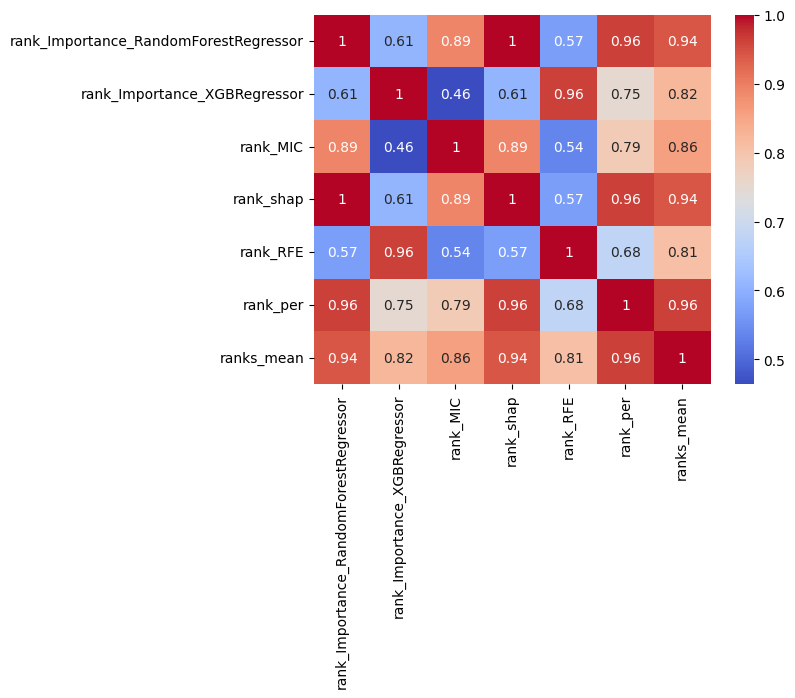

In [44]:
corr = ranks[rank_feat].corr()
sns.heatmap(corr.round(3), 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True, cmap='coolwarm')
plt.xticks(rotation =90);

In [45]:
ranks = ranks.sort_values("ranks_mean")
ranks[["Feat"] + rank_feat]
color = (ranks['Feat'].str.contains('rand')).map({True: 'background-color: red', False: ''})
ranks.style.apply(lambda s: color)

,rank_Importance_RandomForestRegressor,Feat,Importance_RandomForestRegressor,rank_Importance_XGBRegressor,Importance_XGBRegressor,rank_MIC,importance_MIC,rank_shap,shap_importance,rank_RFE,rank_per,ranks_mean
0,0,Rok_produkcji,0.598320,0,0.328940,0,0.458197,0,8640.470754,0,0,0.000000
1,1,KM,0.329408,1,0.180324,1,0.198950,1,3008.157238,1,1,1.000000
2,2,Pojemnosc_silnika,0.049492,4,0.064581,2,0.147421,2,2750.859063,4,2,2.666667
4,4,Uszkodzony,0.009171,2,0.176929,6,0.020994,4,931.090282,3,3,3.666667
5,5,Manualna,0.001836,3,0.168672,4,0.065729,5,808.713270,2,5,4.000000
3,3,Przebieg,0.010553,6,0.035424,3,0.084301,3,1417.106655,6,4,4.166667
6,6,Osoby prywatnej,0.001220,5,0.045130,5,0.034348,6,190.047368,5,6,5.500000


In [46]:
def train_model(data, model, features, YCOL = YCOL):
    X_train = data[data['okres'] == "train"][features]
    y_train = data[data['okres'] == "train"][YCOL]
 
    X_test = data[data['okres'] != "train"][features]
    y_test = data[data['okres'] != "train"][YCOL]
 
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return mean_absolute_error(y_test, y_pred)

In [47]:
params = {"max_depth" : 5,
         "n_estimators" : 150}
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error, median_absolute_error, r2_score, explained_variance_score
import numpy as np

In [48]:
rank_feat

['rank_Importance_RandomForestRegressor',
 'rank_Importance_XGBRegressor',
 'rank_MIC',
 'rank_shap',
 'rank_RFE',
 'rank_per',
 'ranks_mean']

In [49]:
all_results = pd.DataFrame()
 
n_feat_s = []
model_name = []
mae_s = []
rank_type_s = []
features_s = []
 
for rank_type in rank_feat:
    print(f"-------{rank_type}-------")
    
    rank_type_results = pd.DataFrame()
    
    for model in [
                   xgb.XGBRegressor(**params),
                   lgb.LGBMRegressor(**params, verbose = -1),
                   cat.CatBoostRegressor(**params, verbose =0),
                   DecisionTreeRegressor(max_depth=10),
                   RandomForestRegressor(**params)
                 ]:
        for n_feat in range(5,13):
            
            print(f"N features: {n_feat}")
            feat = ranks.sort_values(rank_type)['Feat'].to_list()[0:n_feat]
            mae = train_model(df, model, feat)
        
            n_feat_s.append(str(n_feat))
            model_name.append( str(type(model).__name__))
            mae_s.append(mae)
            rank_type_s.append(rank_type)
            features_s.append(str(feat))


-------rank_Importance_RandomForestRegressor-------
N features: 5
N features: 6
N features: 7
N features: 8
N features: 9
N features: 10
N features: 11
N features: 12
N features: 5
N features: 6
N features: 7
N features: 8
N features: 9
N features: 10
N features: 11
N features: 12
N features: 5
N features: 6
N features: 7
N features: 8
N features: 9
N features: 10
N features: 11
N features: 12
N features: 5
N features: 6
N features: 7
N features: 8
N features: 9
N features: 10
N features: 11
N features: 12
N features: 5
N features: 6
N features: 7
N features: 8
N features: 9
N features: 10
N features: 11
N features: 12
-------rank_Importance_XGBRegressor-------
N features: 5
N features: 6
N features: 7
N features: 8
N features: 9
N features: 10
N features: 11
N features: 12
N features: 5
N features: 6
N features: 7
N features: 8
N features: 9
N features: 10
N features: 11
N features: 12
N features: 5
N features: 6
N features: 7
N features: 8
N features: 9
N features: 10
N features: 11


In [50]:
results = pd.DataFrame({"model_name":model_name,
                         "n_feat_s":n_feat_s,
                         "mae_s":mae_s,
                         "rank_type_s":rank_type_s,
                         "features_s":features_s})


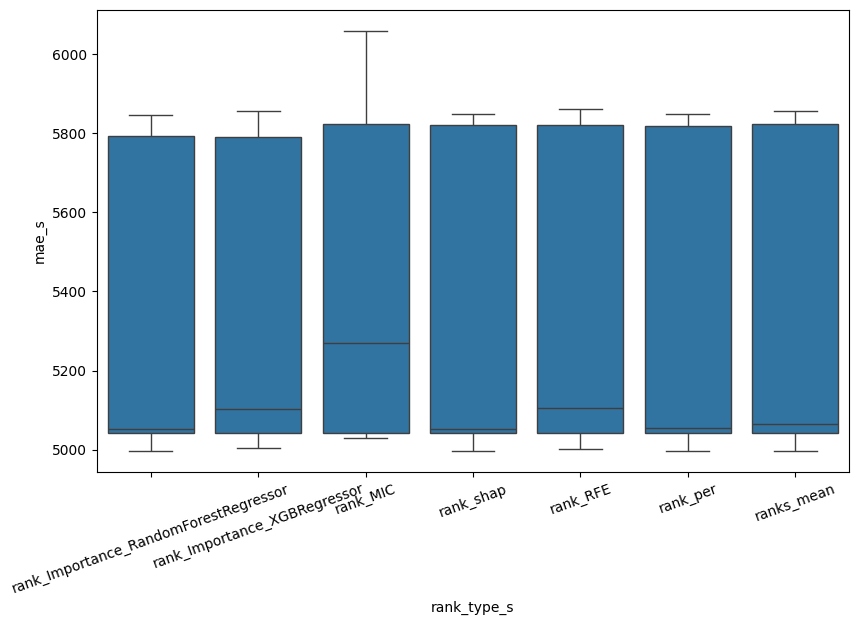

In [51]:
plt.figure(figsize = (6*1.618,6))
sns.boxplot(x= "rank_type_s", y = 'mae_s', data = results);
plt.xticks(rotation =  20);

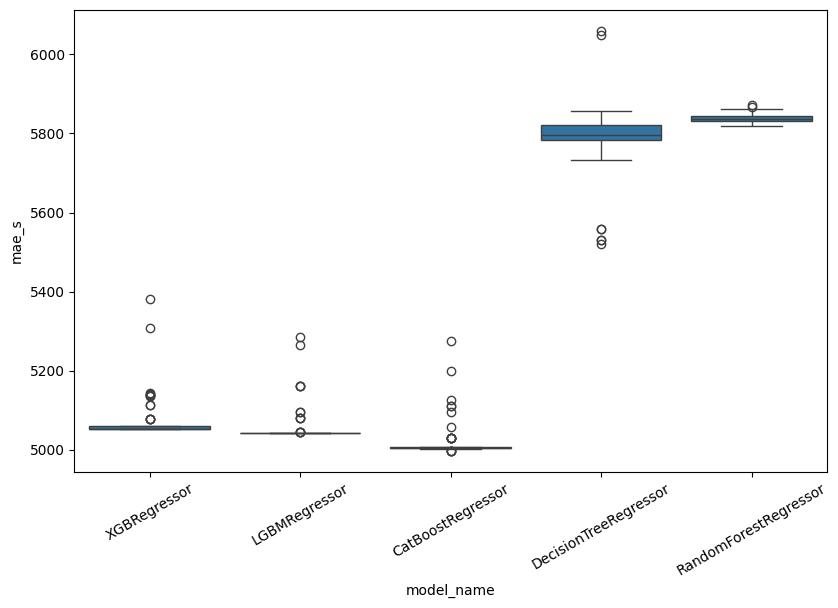

In [52]:
plt.figure(figsize = (6*1.618,6))
sns.boxplot(x= "model_name", y = 'mae_s', data = results);
plt.xticks(rotation = 30);

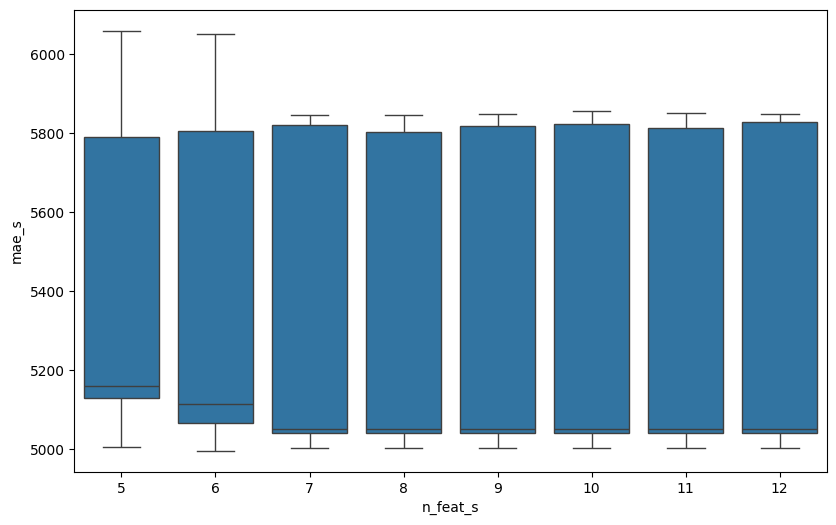

In [53]:
plt.figure(figsize = (6*1.618,6))
sns.boxplot(x= "n_feat_s", y = 'mae_s', data = results);

In [54]:
results.sort_values("mae_s")

,model_name,n_feat_s,mae_s,rank_type_s,features_s
257,CatBoostRegressor,6,4997.161746,ranks_mean,"['Rok_produkcji', 'KM', 'Pojemnosc_silnika', '..."
217,CatBoostRegressor,6,4997.161746,rank_per,"['Rok_produkcji', 'KM', 'Pojemnosc_silnika', '..."
17,CatBoostRegressor,6,4997.161746,rank_Importance_RandomForestRegressor,"['Rok_produkcji', 'KM', 'Pojemnosc_silnika', '..."
137,CatBoostRegressor,6,4997.161746,rank_shap,"['Rok_produkcji', 'KM', 'Pojemnosc_silnika', '..."
178,CatBoostRegressor,7,5002.492876,rank_RFE,"['Rok_produkcji', 'KM', 'Manualna', 'Uszkodzon..."
...,...,...,...,...,...
193,RandomForestRegressor,6,5861.474571,rank_RFE,"['Rok_produkcji', 'KM', 'Manualna', 'Uszkodzon..."
112,RandomForestRegressor,5,5866.899680,rank_MIC,"['Rok_produkcji', 'KM', 'Pojemnosc_silnika', '..."
113,RandomForestRegressor,6,5870.819492,rank_MIC,"['Rok_produkcji', 'KM', 'Pojemnosc_silnika', '..."
105,DecisionTreeRegressor,6,6049.572899,rank_MIC,"['Rok_produkcji', 'KM', 'Pojemnosc_silnika', '..."


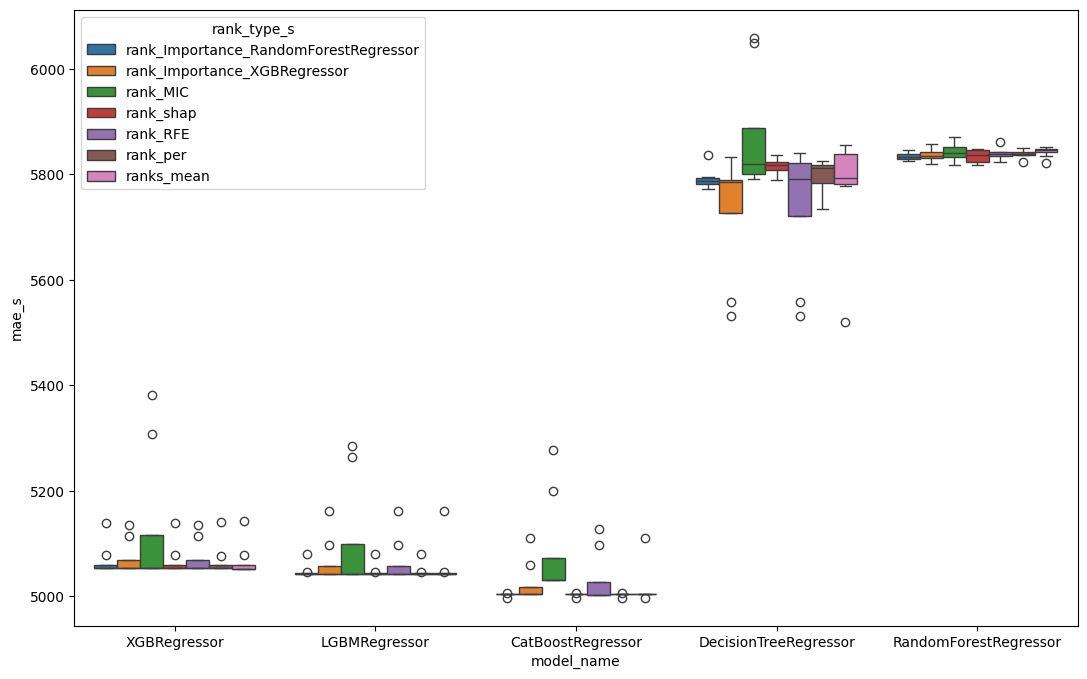

In [55]:
plt.figure(figsize = (8*1.618,8))
sns.boxplot(x= "model_name", y = 'mae_s', hue = 'rank_type_s' ,data = results);